# Tecnicas parametricas

## Ejercicio 3

Para el proceso Y(n) se grafica su PSD, la PSD usando el estimador de Welch y el periodograma

In [1]:

import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

def acorrSesgado(y):
    r = signal.correlate(y, y) / len(y)
    l = np.arange(-(len(y)-1), len(y))
    return r,l

#### PROCESO AR-4 ####

N = np.array([1000,5000]) # Camtodad de muestras
m = 4 # Orden del proceso
a = np.array([ 1, 0.3544,0.3508,0.1736,0.2401 ]) # Coeficientes del proceso DENOM
b = np.array([ 1, 0, 0, 0, 0 ])


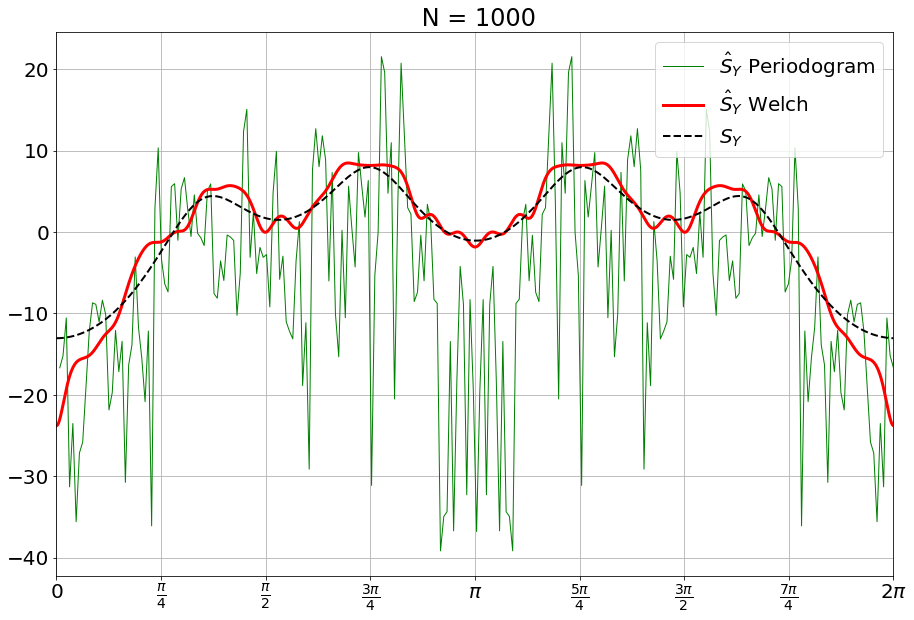

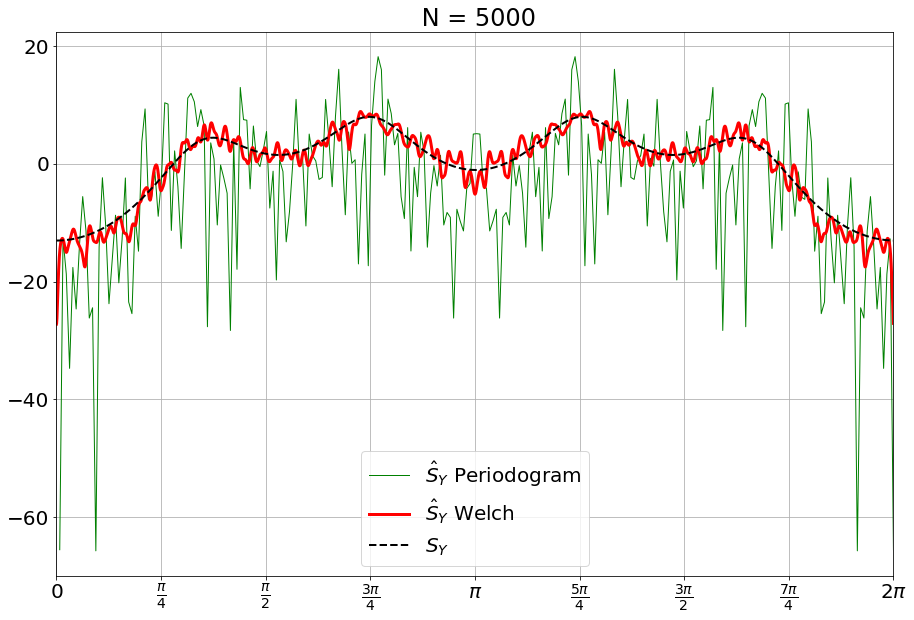

In [19]:

for i in range(N.size):    
    
    w_axis = np.linspace(0,2*np.pi,256)
    # Genero ruido blanco
    W = np.random.normal(0, 1, N[i])
    # Genero el proceso Y
    Y = signal.lfilter(b, a, W)

    # Periodograma!
    w_periodogram,sy_periodogram = signal.periodogram(Y,window = 'bartlett',return_onesided = False , nfft = 256)
    # Respuesta en frecuencia del filtro , PSD teorica
    w_freq,sy_teorico = signal.freqz(b, a, whole = True)
    # Estimador Welch
    if(i == 0):
        f, y_psd = signal.welch(Y , window = 'bartlett', nperseg = 50, 
        nfft = 5000, noverlap = 50/2,return_onesided = False)
    if(i == 1):
        f, y_psd = signal.welch(Y , window = 'bartlett', nperseg = 250, 
        nfft = 5000, noverlap = 250/2,return_onesided = False)
    
    # Graficos
    plt.figure(figsize = (15,10))
    plt.plot( w_axis[1:], 20 * np.log10(sy_periodogram[1:]),
             linewidth = 1, color = 'green', label = r'$\hat{S}_Y$ Periodogram' )
    plt.plot(np.linspace(0,2*np.pi,5000),20 * np.log10(y_psd), 
             linewidth = 3, color = 'red', linestyle = '-', label = r'$\hat{S}_Y$ Welch' )
    plt.plot( np.linspace(0,2*np.pi,512), 20 * np.log10(pow(abs(sy_teorico),2)) , 
             linewidth = 2, color = 'black', linestyle = '--', label = r'$S_Y$')
    plt.xticks([ 0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi, 1.25*np.pi, 1.5*np.pi, 1.75*np.pi , 2* np.pi], 
           ['$0$', r'$\frac{\pi}{4}$', r'$\frac{\pi}{2}$', r'$\frac{3\pi}{4}$', r'$\pi$', 
            r'$\frac{5\pi}{4}$', r'$\frac{3\pi}{2}$', r'$\frac{7\pi}{4}$',r'$2\pi$' ])
    plt.grid(True)
    plt.title(" N = {}".format(N[i]))
    plt.legend(loc = 'best')
    plt.xlim(0,np.pi*2)    
    plt.rc('font', size=20)         


Lo ideal para el periodograma seria tomar un promedio entre varios periodogramas.

## Ejercicio 4
#### Comparacion entre el estimador MV y el estimador de Welch

### 1) Coeficientes de de orden 4 y elegidos por la metrica Akaike

In [25]:
### Generacion de muestras de Y(n) ####
N = 1000 # Camtodad de muestras
m = 4 # Orden del proceso
a = np.array([ 1, 0.3544,0.3508,0.1736,0.2401 ]) # Coeficientes del proceso DENOM
b = np.array([ 1, 0, 0, 0, 0 ]) 
# Genero ruido blanco
W = np.random.normal(0, 1, N)
# Genero muestras del proceso Y(n)
Y = signal.lfilter(b, a, W)
print(a)

[1.     0.3544 0.3508 0.1736 0.2401]


In [23]:
## Estimador de maxima verosimilitud de los coeficientes de a :
def estimadorCoefMV(y, m,):
    
    N = y.size
    
    # y monio es (N-m-1)x1
    yy = np.zeros((N-m,1))
    for i in range(N-m):
        yy[i] = y[i+m]
    yy = yy[::-1]
    
    # para m <= n <= N se define y(n) = [y(n),...,y(n-m+1)] mx1
    YY = np.zeros((m,N-m))
    for i in range(m):
        for j in range(N-m):
            YY[i][j] = y[N-j-i-2]
    # ecuacion normal
    a_mv = np.dot( np.dot( np.linalg.inv( np.dot(YY,YY.T) ) , YY ) , yy )  
    # En el calculo se definieron los coeficientes como negativos 1 - a1*Y(n-1) - a2*Y(n-2) - a3*Y(n-3) - a4*Y(n-4)
    # Entonces como en teoria son positivos, a_mv los devuelve negativos
    sigma_mv = pow(np.linalg.norm( yy - np.dot(YY.T,a_mv) ),2)/(N-m)
    
    return a_mv , sigma_mv

# Metrica de Akaike
def AIC(m, sigma):
    return 2 * (m + 1) + 2 * N * (1+np.log(2*np.pi*sigma))

In [22]:
a_mv , sigma_mv = estimadorCoefMV(Y, 4)
print("Coeficientes de orden 4 por MV:")
print(-a_mv)
print("Sigma por MV:",sigma_mv)
a_mv = np.append(1, -a_mv)

Coeficientes de orden 4 por MV:
[[0.33048055]
 [0.33221576]
 [0.16214202]
 [0.2822765 ]]
Sigma por MV: 0.9739947775193897


In [26]:
# --------------------------------------------------------------------------------------#
# Se busca el orden m usando el criterio de Akaike y luego se estiman los coeficientes #
# --------------------------------------------------------------------------------------#

aic = np.zeros(10)
# [m=1, m=2, m=3, m=4, m=5, m=6 ,... , m=10]
a_mv_lista = []
sigma_mv_lista = []
for mm in range(1,11):
    coef , sigma_MV = estimadorCoefMV(Y, mm)
    a_mv_lista.append(coef)
    sigma_mv_lista.append(sigma_MV)
    
    #print('\n')
    #print("Para m = {}:".format(m))
    #print("Coeficientes:")
    #print(-a_mv_lista[m-1])
    #print("Varianza = ", sigma_MV)
    
    aic[mm-1] = AIC(mm,sigma_MV)

# Imprime el indice + 1, seria el orden m
print("\nMinimo AIC(m):")
m_aic = np.argmin(aic)+1 # La minima metrica de Akaike
print("m = ", m_aic)
print("AIC({})".format(m_aic), aic[m_aic-1])
a_mv_aic = np.zeros(m_aic)
a_mv_aic = np.append(1, -a_mv_lista[m_aic - 1])
sigma_mv_aic = sigma_mv_lista[m_aic - 1]
print("Sigma = ", sigma_mv_aic)
print("Coeficientes:")
print(a_mv_aic.T)
print('\n')



Minimo AIC(m):
m =  9
AIC(9) 5626.464348405638
Sigma =  0.9659483711556743
Coeficientes:
[ 1.          0.39042282  0.33265405  0.13226399  0.13321771 -0.06356672
 -0.01236969 -0.03715301 -0.03172236 -0.04782377]




### 2) Diferencia entre la metrica de Akaike y el minimo de ellos

In [27]:
# Diferencia entre la metrica de Akaike 1...10 y la minima:
for mm in range(1,11):
    delta = aic[mm-1] - aic[m_aic-1]
    print(r'Δ'+"({})".format(mm)+"=AIC({})".format(mm)+"-minAIC({})".format(m_aic))
    print(delta)

Δ(1)=AIC(1)-minAIC(9)
222.17987139888555
Δ(2)=AIC(2)-minAIC(9)
85.29058080076175
Δ(3)=AIC(3)-minAIC(9)
69.75933062266631
Δ(4)=AIC(4)-minAIC(9)
22.622820181637508
Δ(5)=AIC(5)-minAIC(9)
5.948161711270586
Δ(6)=AIC(6)-minAIC(9)
6.151037179092782
Δ(7)=AIC(7)-minAIC(9)
8.594963367393575
Δ(8)=AIC(8)-minAIC(9)
2.72339159027797
Δ(9)=AIC(9)-minAIC(9)
0.0
Δ(10)=AIC(10)-minAIC(9)
2.6832386178975867


### 3) Comparacion

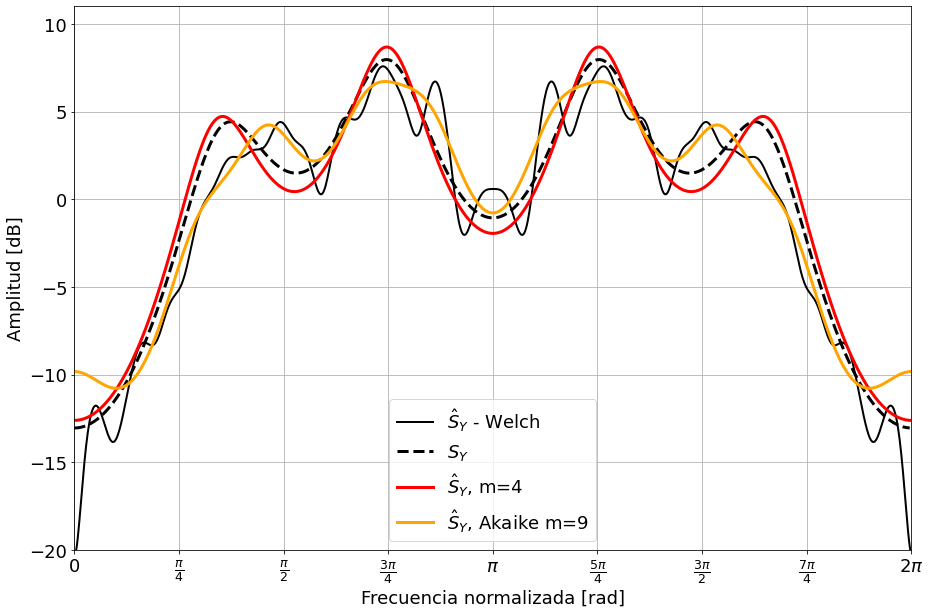

In [29]:
plt.figure(figsize = (15,10))

# Estimador de Welch:
w_axis, y_psd = signal.welch(Y , window = 'bartlett', nperseg = 50, noverlap = 50/2 ,nfft = N, return_onesided = False)
plt.plot(np.linspace(0,2*np.pi,1000), 20 * np.log10(pow(abs(y_psd),1)), label = r'$\hat{S}_Y$ - Welch', color = 'black', 
          linewidth = 2)

# PSD verdadera:
f, psd = signal.freqz(b, a, whole = True)
plt.plot(f, 20 * np.log10(pow(abs(psd),2)), label = r'$S_Y$', linestyle = '--', color = 'black', linewidth = 3)

# Por estimador MV de orden 4
f_mv, psd_mv = signal.freqz(b, a_mv, whole = True)
plt.plot(f_mv, 20 * np.log10(pow(abs(psd_mv),2))*sigma_mv, label = r'$\hat{S}_Y$, m=4', color = 'red', linewidth = 3)

# Por estimador MV y akaike
f_mv_aic, psd_mv_aic = signal.freqz(b, a_mv_aic, whole = True)
plt.plot(f_mv_aic, 20 * np.log10(pow(abs(psd_mv_aic),2))*sigma_mv_aic, label = r'$\hat{S}_Y$,'+" Akaike m={}".format(m_aic) ,
         color = 'orange', linewidth = 3)


plt.xticks([ 0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi, 1.25*np.pi, 1.5*np.pi, 1.75*np.pi , 2* np.pi], 
           ['$0$', r'$\frac{\pi}{4}$', r'$\frac{\pi}{2}$', r'$\frac{3\pi}{4}$', r'$\pi$', 
            r'$\frac{5\pi}{4}$', r'$\frac{3\pi}{2}$', r'$\frac{7\pi}{4}$',r'$2\pi$' ])
plt.legend(loc = 'best')
plt.xlabel("Frecuencia normalizada [rad]")
plt.ylabel(r'Amplitud [dB]')
plt.xlim(0,2*np.pi)
plt.ylim(-20,11)
plt.grid(True)
plt.rc('font', size=18)


### 4) Repetirlo 2000 veces

Text(0, 0.5, 'Probabilidad')

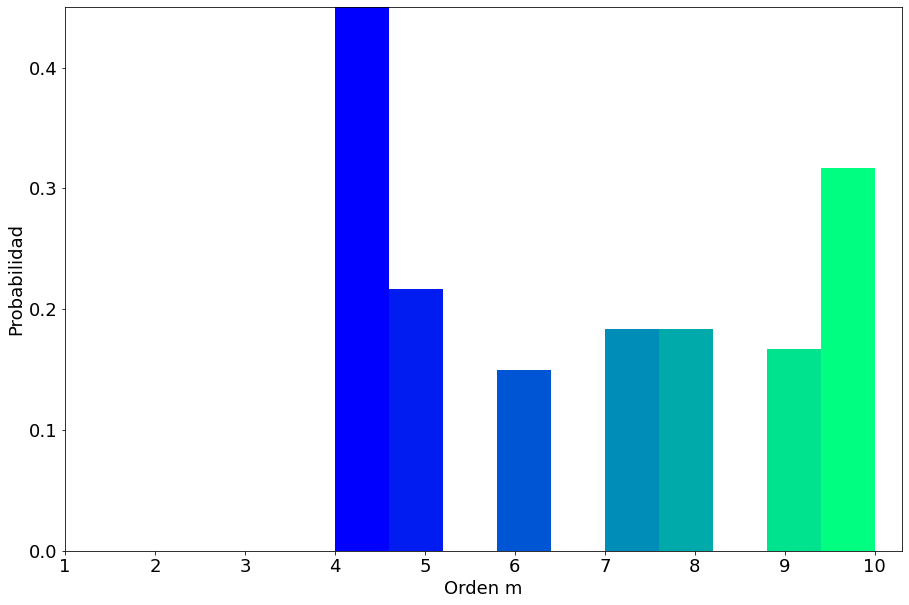

In [30]:

# Para 2000 el tiempo de carga es demasiado... Lo pongo en 100 y despues lo camibo
orden = np.zeros(100)
for i in range(100): 
    
    ruido = np.random.normal(0, 1, N)
    y = signal.lfilter(b, a, ruido)
    orden[i] = 1
    min_aic = 0
    
    for mm in range(1,11):
        
        coef, sigmas = estimadorCoefMV(y,mm)
        _aic = AIC(mm,sigmas)
        # Busco el menor:
        if mm == 1:
            min_aic = _aic
        if _aic < min_aic:
            min_aic = _aic
            orden[i] = mm # Orden dado por la metrica
            
plt.figure(figsize = (15,10))
hist, bins, patches = plt.hist(orden, bins = 10, density = True)        
plt.xticks(range(1,11))       
colores = iter( ( plt.get_cmap('winter') )( np.linspace(0,1,len(patches)) ) )
for i in range(len(patches)):
    patches[i].set_facecolor(next(colores))
plt.yticks(np.arange(0,1,0.1))        
plt.ylim(0,np.max(hist))        
plt.xlabel("Orden m")        
plt.ylabel("Probabilidad")       


## Ejercicio 5
Dado el archivo Ej4.csv estimar su PSD

In [38]:
# Obtengo las muestras
from pandas import read_csv

y = read_csv('Ej4.csv', sep=',' , header = None)
y = y.to_numpy()

# Encuentro el mejor orden m:
aic = 0
aic_min = 0
sigma_aic = 0
for m in range(1,21):
    
    a_mv, sigma = estimadorCoefMV(y, m)
    aic = AIC(m, sigma)

    if m == 1:
        aic_min = aic
    if aic < aic_min:
        aic_min = aic
        orden = m
        a = np.append(1,-a_mv)
        sigma_aic = sigma

f_welch, psd_welch = signal.welch(y ,nperseg = 250, noverlap = 250/2 ,nfft = 5000
                                  , window = 'bartlett',return_onesided = False, axis = 0)

f, psd_aic = signal.freqz(np.array([ 1 ]) , a, whole = True)


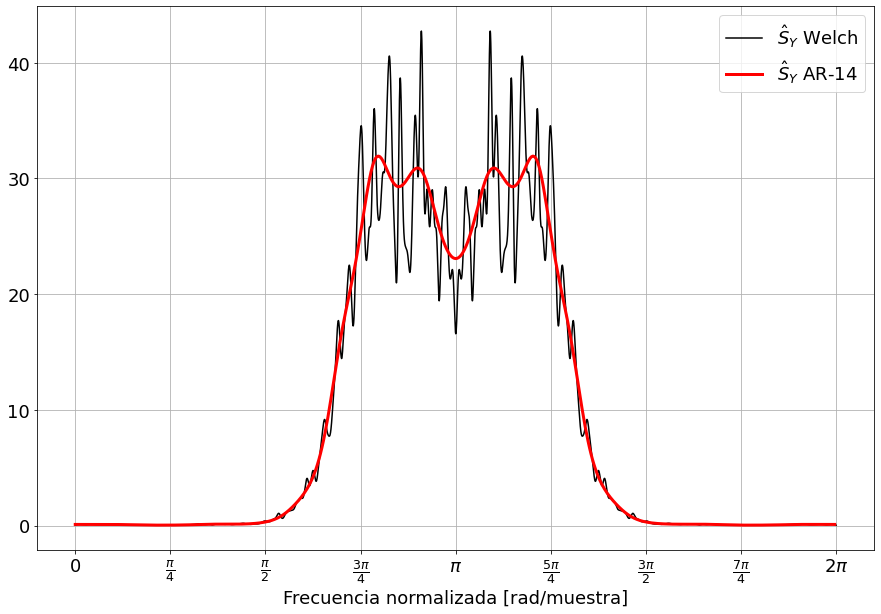

In [37]:
plt.figure(figsize = (15,10))
plt.plot(np.linspace(0,2*np.pi,5000), (psd_welch), 
         label = r'$\hat{S}_Y$' + " Welch" , color = 'black')
plt.plot(f,sigma_aic * abs( psd_aic)**2 , color = 'red', linewidth = 3, 
         label = r'$\hat{S}_Y$'+" AR-{}".format(orden))
plt.legend(loc = 'best')
plt.xlabel("Frecuencia normalizada [rad/muestra]")
plt.xticks([ 0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi, 1.25*np.pi, 1.5*np.pi, 1.75*np.pi , 2* np.pi], 
           ['$0$', r'$\frac{\pi}{4}$', r'$\frac{\pi}{2}$', r'$\frac{3\pi}{4}$', 
            r'$\pi$',  r'$\frac{5\pi}{4}$', r'$\frac{3\pi}{2}$', r'$\frac{7\pi}{4}$',r'$2\pi$' ])
plt.rc('font', size=18)
plt.grid(True)


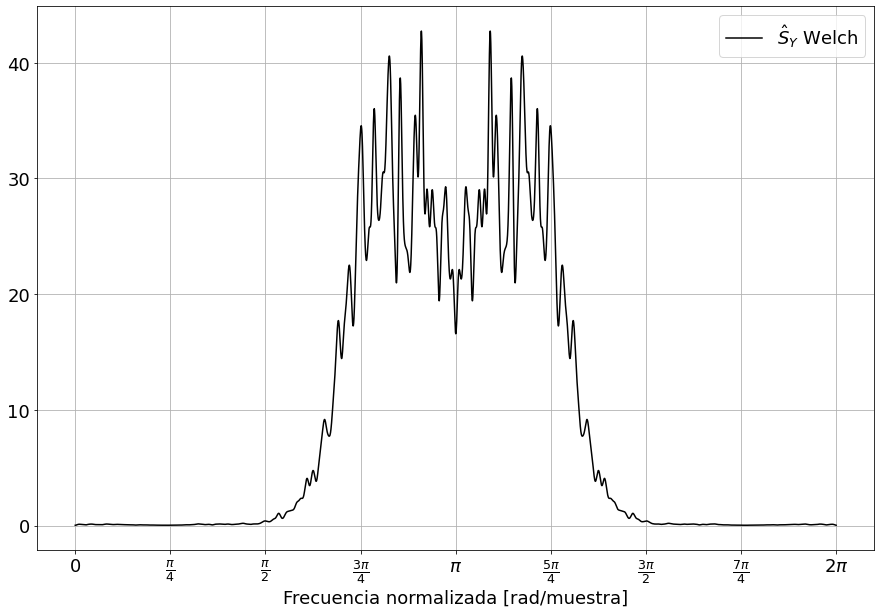

In [35]:

plt.figure(figsize = (15,10))
plt.plot(np.linspace(0,2*np.pi,5000), (psd_welch), 
         label = r'$\hat{S}_Y$' + " Welch" , color = 'black')
plt.legend(loc = 'best')
plt.xlabel("Frecuencia normalizada [rad/muestra]")
plt.xticks([ 0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi, 1.25*np.pi, 1.5*np.pi, 1.75*np.pi , 2* np.pi], 
           ['$0$', r'$\frac{\pi}{4}$', r'$\frac{\pi}{2}$', r'$\frac{3\pi}{4}$', 
            r'$\pi$',  r'$\frac{5\pi}{4}$', r'$\frac{3\pi}{2}$', r'$\frac{7\pi}{4}$',r'$2\pi$' ])
plt.grid(True)


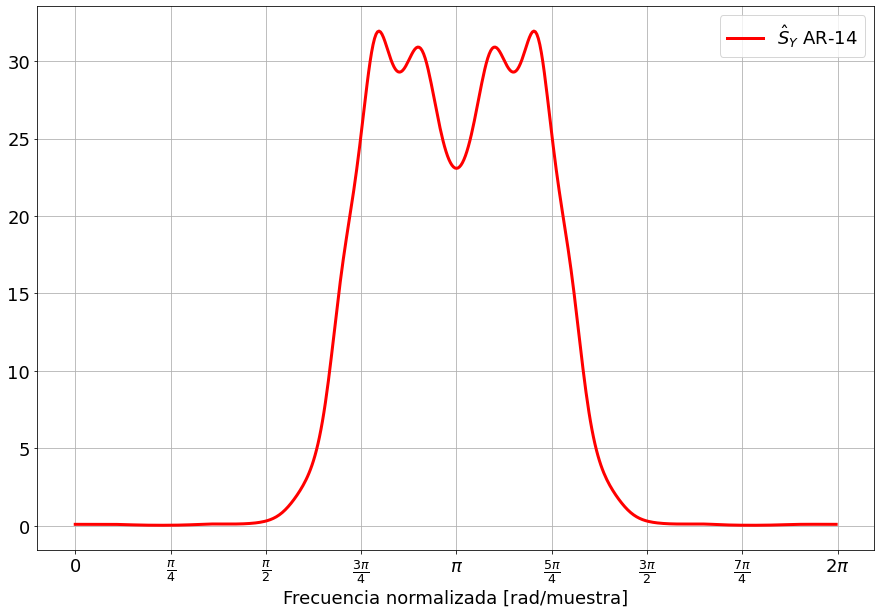

In [36]:

plt.figure(figsize = (15,10))
plt.plot(f,sigma_aic * abs( psd_aic)**2 , color = 'red', linewidth = 3, 
         label = r'$\hat{S}_Y$'+" AR-{}".format(orden))
plt.legend(loc = 'best')
plt.xlabel("Frecuencia normalizada [rad/muestra]")
plt.xticks([ 0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi, 1.25*np.pi, 1.5*np.pi, 1.75*np.pi , 2* np.pi], 
           ['$0$', r'$\frac{\pi}{4}$', r'$\frac{\pi}{2}$', r'$\frac{3\pi}{4}$', 
            r'$\pi$',  r'$\frac{5\pi}{4}$', r'$\frac{3\pi}{2}$', r'$\frac{7\pi}{4}$',r'$2\pi$' ])
plt.grid(True)
